# Implémentez un modèle de scoring

In [1]:
# librairies de base
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import gc
import time
from contextlib import contextmanager

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

# Données brutes

- **application_{train|test}.csv**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

- **bureau.csv**

Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

- **bureau_balance.csv**

Soldes mensuels des crédits antérieurs au bureau de crédit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

- **POS_CASH_balance.csv**

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

- **credit_card_balance.csv**

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

- **previous_application.csv**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

- **installments_payments.csv**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon. Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

- **HomeCredit_columns_description.csv**

Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [2]:
# Set the path to the data directory
path = os.path.join('..', 'data')

# Load the application train and test data
df_application_train = pd.read_csv(os.path.join(path, "application_train.csv"))
df_application_test = pd.read_csv(os.path.join(path, "application_test.csv"))

# Load the bureau, bureau balance, credit card balance,
# installments payments, previous application, and POS cash balance data
df_bureau = pd.read_csv(os.path.join(path, "bureau.csv"))
df_bureau_balance = pd.read_csv(os.path.join(path, "bureau_balance.csv"))
df_credit_card_balance = pd.read_csv(os.path.join(path, "credit_card_balance.csv"))
df_installments_payments = pd.read_csv(os.path.join(path, "installments_payments.csv"))
df_previous_application = pd.read_csv(os.path.join(path, "previous_application.csv"))
df_POS_CASH_balance = pd.read_csv(os.path.join(path, "POS_CASH_balance.csv"))

In [3]:
print("Shape of data")

# Create a list of tuples to store the names and shapes of each DataFrame
df_list = [
    ('application_train', df_application_train.shape),
    ('application_test', df_application_test.shape),
    ('bureau', df_bureau.shape),
    ('bureau_balance', df_bureau_balance.shape),
    ('POS_CASH_balance', df_POS_CASH_balance.shape),
    ('credit_card_balance', df_credit_card_balance.shape),
    ('installments_payments', df_installments_payments.shape),
    ('previous_application', df_previous_application.shape)
]

# Iterate over the list and print the names and shapes
for name, shape in df_list:
    print(f'{name} shape: {shape}')


Shape of data
application_train shape: (307511, 122)
application_test shape: (48744, 121)
bureau shape: (1716428, 17)
bureau_balance shape: (27299925, 3)
POS_CASH_balance shape: (10001358, 8)
credit_card_balance shape: (3840312, 23)
installments_payments shape: (13605401, 8)
previous_application shape: (1670214, 37)


In [4]:
print("Number of 'inf'")

# Create a list of tuples to store the names and counts of 'inf' values in each DataFrame
df_list = [
    ('application_train', (df_application_train == 'inf').sum().sum()),
    ('application_test', (df_application_test == 'inf').sum().sum()),
    ('bureau', (df_bureau == 'inf').sum().sum()),
    ('bureau_balance', (df_bureau_balance == 'inf').sum().sum()),
    ('POS_CASH_balance', (df_POS_CASH_balance == 'inf').sum().sum()),
    ('credit_card_balance', (df_credit_card_balance == 'inf').sum().sum()),
    ('installments_payments', (df_installments_payments == 'inf').sum().sum()),
    ('previous_application', (df_previous_application == 'inf').sum().sum())
]

# Iterate over the list and print the names and counts
for name, count in df_list:
    print(f'{name} shape: {count}')


Number of 'inf'
application_train shape: 0
application_test shape: 0
bureau shape: 0
bureau_balance shape: 0
POS_CASH_balance shape: 0
credit_card_balance shape: 0
installments_payments shape: 0
previous_application shape: 0


In [5]:
print("Number of NaN")

df_list = [
    ('application_train', df_application_train.isna().sum().sum()),
    ('application_test', df_application_test.isna().sum().sum()),
    ('bureau', df_bureau.isna().sum().sum()),
    ('bureau_balance', df_bureau_balance.isna().sum().sum()),
    ('POS_CASH_balance', df_POS_CASH_balance.isna().sum().sum()),
    ('credit_card_balance', df_credit_card_balance.isna().sum().sum()),
    ('installments_payments', df_installments_payments.isna().sum().sum()),
    ('previous_application', df_previous_application.isna().sum().sum())
]

for name, count in df_list:
    print(f'{name} shape: {count}')


Number of NaN
application_train shape: 9152465
application_test shape: 1404419
bureau shape: 3939947
bureau_balance shape: 0
POS_CASH_balance shape: 52158
credit_card_balance shape: 5877356
installments_payments shape: 5810
previous_application shape: 11109336


In [6]:
from contextlib import contextmanager

# Custom context manager for measuring execution time
@contextmanager
def timer(title):
    # Start time
    t0 = time.time()
    
    yield
    
    # Calculate and print elapsed time
    print(f"{title} - done in {time.time() - t0:.0f}s")


# Functions

In [7]:
def one_hot_encoder(df, nan_as_category=True):
    # Store the original columns of the DataFrame
    orig_cols = list(df.columns)
    
    # Identify categorical columns
    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    
    # Perform one-hot encoding using get_dummies
    encoded_df = pd.get_dummies(df, columns=cat_cols, dummy_na=nan_as_category)
    
    # Retrieve the newly created columns
    new_cols = [c for c in encoded_df.columns if c not in orig_cols]
    
    return encoded_df, new_cols


In [8]:
def application_data(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows=num_rows)
    test_df = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # Merge train and test data
    df = df.append(test_df).reset_index()
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feat in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feat], uniques = pd.factorize(df[bin_feat])
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Create some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Cleanup
    del test_df
    gc.collect()
    
    return df


In [9]:
def bureau_and_balance_data(num_rows=None, nan_as_category=True):
    bureau_df = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows=num_rows)
    bb_df = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows=num_rows)
    
    # Perform one-hot encoding
    bb_df, bb_cat_cols = one_hot_encoder(bb_df, nan_as_category)
    bureau_df, bureau_cat_cols = one_hot_encoder(bureau_df, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat_cols:
        bb_aggregations[col] = ['mean']
    bb_agg = bb_df.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau_df = bureau_df.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau_df.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb_df, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat_cols:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat_cols:
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau_df.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active_df = bureau_df[bureau_df['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active_df.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active_df, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed_df = bureau_df[bureau_df['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed_df.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed_df, closed_agg, bureau_df
    gc.collect()
    
    return bureau_agg


In [10]:
def previous_applications_data(num_rows=None, nan_as_category=True):
    prev_df = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows=num_rows)
    
    # Perform one-hot encoding
    prev_df, cat_cols = one_hot_encoder(prev_df, nan_as_category=True)
    
    # Replace Days 365.243 values with NaN
    prev_df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev_df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev_df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev_df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev_df['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Add feature: value ask / value received percentage
    prev_df['APP_CREDIT_PERC'] = prev_df['AMT_APPLICATION'] / prev_df['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev_df.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev_df[prev_df['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev_df[prev_df['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev_df
    gc.collect()
    
    return prev_agg


In [11]:
def pos_cash_data(num_rows=None, nan_as_category=True):
    pos_df = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows=num_rows)
    
    # Perform one-hot encoding
    pos_df, cat_cols = one_hot_encoder(pos_df, nan_as_category)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos_df.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos_df.groupby('SK_ID_CURR').size()
    
    del pos_df
    gc.collect()
    
    return pos_agg


In [12]:
def installments_payments_data(num_rows=None, nan_as_category=True):
    ins_df = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows=num_rows)
    
    # Perform one-hot encoding
    ins_df, cat_cols = one_hot_encoder(ins_df, nan_as_category=True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins_df['PAYMENT_PERC'] = ins_df['AMT_PAYMENT'] / ins_df['AMT_INSTALMENT']
    ins_df['PAYMENT_DIFF'] = ins_df['AMT_INSTALMENT'] - ins_df['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins_df['DPD'] = ins_df['DAYS_ENTRY_PAYMENT'] - ins_df['DAYS_INSTALMENT']
    ins_df['DBD'] = ins_df['DAYS_INSTALMENT'] - ins_df['DAYS_ENTRY_PAYMENT']
    ins_df['DPD'] = ins_df['DPD'].apply(lambda x: x if x > 0 else 0)
    ins_df['DBD'] = ins_df['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    ins_agg = ins_df.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins_df.groupby('SK_ID_CURR').size()
    
    del ins_df
    gc.collect()
    
    return ins_agg


In [13]:
def credit_card_balance_data(num_rows=None, nan_as_category=True):
    cc_df = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows=num_rows)
    
    # Perform one-hot encoding
    cc_df, cat_cols = one_hot_encoder(cc_df, nan_as_category=True)
    
    # Drop SK_ID_PREV column
    cc_df.drop(['SK_ID_PREV'], axis=1, inplace=True)
    
    # General aggregations
    cc_agg = cc_df.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc_df.groupby('SK_ID_CURR').size()
    
    del cc_df
    gc.collect()
    
    return cc_agg


# Création du DataFrame final

In [14]:
def main(debug=False):
    num_rows = 10000 if debug else None
    application_df = application_data(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau_df = bureau_and_balance_data(num_rows)
        print("Bureau df shape:", bureau_df.shape)
        application_df = application_df.join(bureau_df, how='left', on='SK_ID_CURR')
        del bureau_df
        gc.collect()
    with timer("Process previous_applications"):
        prev_df = previous_applications_data(num_rows)
        print("Previous applications df shape:", prev_df.shape)
        application_df = application_df.join(prev_df, how='left', on='SK_ID_CURR')
        del prev_df
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos_df = pos_cash_data(num_rows)
        print("Pos-cash balance df shape:", pos_df.shape)
        application_df = application_df.join(pos_df, how='left', on='SK_ID_CURR')
        del pos_df
        gc.collect()
    with timer("Process installments payments"):
        ins_df = installments_payments_data(num_rows)
        print("Installments payments df shape:", ins_df.shape)
        application_df = application_df.join(ins_df, how='left', on='SK_ID_CURR')
        del ins_df
        gc.collect()
    with timer("Process credit card balance"):
        cc_df = credit_card_balance_data(num_rows)
        print("Credit card balance df shape:", cc_df.shape)
        application_df = application_df.join(cc_df, how='left', on='SK_ID_CURR')
        del cc_df
        gc.collect()
    return application_df


In [15]:
if __name__ == "__main__":
    submission_file_name = os.path.join(path, "submission_kernel02.csv")
    with timer("Full model run"):
        df_final = main()


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 54s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 64s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 36s
Installments payments df shape: (339587, 26)
Process installments payments - done in 78s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 51s
Full model run - done in 297s


# Traitement

In [16]:
df_final = df_final.copy().dropna(subset=['TARGET'])
df_final.shape

(307507, 678)

# Enlever les colonnes avant plus de 45% de NaN

In [17]:
for col in df_final.columns :
    if df_final[col].isna().sum()/df_final[col].shape[0]  > .45 :
        print(col)
        del df_final[col]

OWN_CAR_AGE


EXT_SOURCE_1
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
FONDKAPREMONT_MODE
HOUSETYPE_MODE
TOTALAREA_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
BURO_AMT_ANNUITY_MAX
BURO_AMT_ANNUITY_MEAN
BURO_MONTHS_BALANCE_MIN_MIN
BURO_MONTHS_BALANCE_MAX_MAX
BURO_MONTHS_BALANCE_SIZE_MEAN
BURO_STATUS_0_MEAN_MEAN
BURO

# Enlever les index ayant toutes ses colonnes vides

In [18]:
df_final = df_final.dropna(how='all')
df_final.drop('index',axis=1,inplace=True)

# Afficher les pourcentages et nombre de NaN par colonnes

In [19]:
# Create an empty DataFrame to store NaN information
df_nan = pd.DataFrame(index=df_final.columns,
                      columns=['Number_of_NaN', 'Pourcentage_of_NaN'])

# Iterate over each column in df_final
for col in df_final.columns:
    # Calculate the number of NaN values in the column and store it in the DataFrame
    df_nan['Number_of_NaN'][col] = df_final[col].isna().sum()

    # Calculate the percentage of NaN values in the column and store it in the DataFrame
    df_nan['Pourcentage_of_NaN'][col] = round(df_final[col].isna().sum() / df_final[col].shape[0] * 100, 1)

# Sort the DataFrame based on the percentage of NaN values in descending order
df_nan = df_nan.sort_values(by='Pourcentage_of_NaN', ascending=False)

# Display the top 50 rows of the DataFrame
df_nan.head(50)

,Number_of_NaN,Pourcentage_of_NaN
CLOSED_DAYS_CREDIT_VAR,130851,42.6
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,123625,40.2
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,118783,38.6
CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,108539,35.3
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,100997,32.8
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,100997,32.8
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,99324,32.3
ACTIVE_DAYS_CREDIT_ENDDATE_MIN,99324,32.3
ACTIVE_DAYS_CREDIT_ENDDATE_MAX,99324,32.3
OCCUPATION_TYPE,96389,31.3


# Enlever les inf

In [20]:
# Using DataFrame.isin() to Create Filter
df_filter = df_final.isin([np.nan,np.inf,-np.inf])
# Mask df with the filter
df_final = df_final[~df_filter]

In [21]:
for col in df_final.columns:
    print(f'{col :-<70} {(df_final[col] == np.inf).sum()}')

SK_ID_CURR------------------------------------------------------------ 0
TARGET---------------------------------------------------------------- 0
NAME_CONTRACT_TYPE---------------------------------------------------- 0
CODE_GENDER----------------------------------------------------------- 0
FLAG_OWN_CAR---------------------------------------------------------- 0
FLAG_OWN_REALTY------------------------------------------------------- 0
CNT_CHILDREN---------------------------------------------------------- 0
AMT_INCOME_TOTAL------------------------------------------------------ 0
AMT_CREDIT------------------------------------------------------------ 0
AMT_ANNUITY----------------------------------------------------------- 0
AMT_GOODS_PRICE------------------------------------------------------- 0
NAME_TYPE_SUITE------------------------------------------------------- 0
NAME_INCOME_TYPE------------------------------------------------------ 0
NAME_EDUCATION_TYPE--------------------------------

In [22]:
df_final_without_ID = df_final.drop('SK_ID_CURR',axis=1)

In [23]:
# Nombre de classe 1 prédites
nb_1 = df_final_without_ID['TARGET'][df_final_without_ID['TARGET'] == 1].shape[0]
# Nombre de classe 0 prédites
nb_0 = df_final_without_ID['TARGET'][df_final_without_ID['TARGET'] == 0].shape[0]

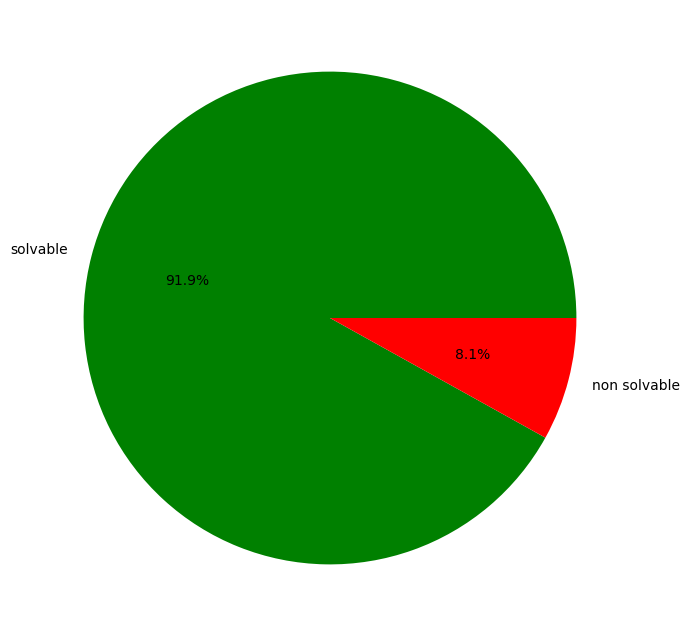

In [24]:
# Calcul du taux de 0, Imbalanced data rate
plt.figure(figsize = (8, 8))
plt.pie([nb_0,nb_1],labels=['solvable','non solvable'],autopct='%.1f%%',colors='gr')
plt.show()

# Sampled data

In [25]:
# Sampler le dataset pour obtenir des temps de traitement plus raisonnable
df_sample = df_final_without_ID.sample(frac=(1/16),random_state=42)

In [26]:
# Vérifier si la proportion est respectée
df_sample.iloc[:,0].value_counts(normalize = True).round(2).unique()

array([0.92, 0.08])

In [27]:
df_sample.to_csv(os.path.join('..','data','preprocessed_data.csv'),index=False)
df_final_without_ID.to_csv(os.path.join('..','data','df_final.csv'),index=False)